### Pip Installs

In [2]:
!pip install datasets
!pip install optuna
!pip install wikidata
!pip install wikipedia-api
!pip install pytorch_lightning
!pip install evaluate

### Imports from various libraries and files

In [3]:
import torch
import numpy as np
import pandas as pd
from typing import Dict
import torch
import matplotlib.pyplot as plt
from transformers import DataCollatorWithPadding
from datasets import load_dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    set_seed,
)
from datasets import Dataset
from tqdm.notebook import tqdm
import evaluate
import wikipediaapi
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score
import sys
from wikidata.client import Client
from urllib.parse import quote, unquote, urlparse
import optuna
from pytorch_lightning.utilities.model_summary import ModelSummary

### Import from drive **see README.txt for more info**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Gradient_Explorers_shared_folder/scripts'
path_test_csv = '/content/drive/MyDrive/Gradient_Explorers_shared_folder/test_unlabeled.csv'
path_weights = '/content/drive/MyDrive/Gradient_Explorers_shared_folder/best_param_model_1'
sys.path.append(path)

from utils import extract_entity_id

Mounted at /content/drive


### Secret Token from HuggingFace **see README.txt for more info**

In [7]:
from huggingface_hub import login
from google.colab import userdata

hf_token = userdata.get('HF_TOKEN')
login(token=hf_token)

### Loading the dataset from locale if present

In [8]:
dataset = load_dataset('sapienzanlp/nlp2025_hw1_cultural_dataset')
dataset_train = dataset['train'].to_pandas()
dataset_validation = dataset['validation'].to_pandas()
dataset_test_csv = pd.read_csv(path_test_csv)
if 'label' not in dataset_test_csv.columns:
    dataset_test_csv['label'] = 0
dataset_test = Dataset.from_pandas(dataset_test_csv)

README.md:   0%|          | 0.00/2.31k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/946k [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/45.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6251 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/300 [00:00<?, ? examples/s]

### Function to extract the summary of wikipedia from wikidata and moidfy the database with the new summary

In [21]:
def extract_summary(dataset, path, name_file = 'summary.csv'):
    try:
        values = pd.read_csv(path)
        print('value loaded')
        return values
    except:
        client = Client()
        wiki = wikipediaapi.Wikipedia(
            user_agent='MyWikiSummaryGetter/1.0 (https://example.org/wiki_summary_getter; user@example.org)',
            language='en'
        )
        properties_df = pd.DataFrame(columns=['item', 'summary'])
        for idx, row in dataset.iterrows():
            """add the properties to the dataset"""

            item = row['item']
            id = extract_entity_id(item)
            try:
                item = client.get(id, load=True)
                sitelinks = item.data.get('sitelinks', {})
                enwiki_sitelink = sitelinks.get('enwiki')['url']

                path = urlparse(enwiki_sitelink).path
                page_title_encoded = path[len('/wiki/'):]
                page_title = unquote(page_title_encoded).replace('_', ' ')
                page_py = wiki.page(page_title)
                summary = page_py.summary
            except:
                summary = str(row['name']) + ', ' + str(row['description']) + ', ' + str(row['category']) + ', ' + str(row['subcategory']) + ', ' + str(row['type'])

            index = properties_df.index.max() + 1 if not properties_df.empty else 0
            properties_df.loc[index, 'item'] = id
            properties_df.loc[index, 'summary'] = summary

            print(f"Processed {idx} rows", end='\r')

        properties_df.to_csv(name_file, index=False)
    return properties_df

In [24]:
 def modify_dataset(x):
      item_id = extract_entity_id(x['item'])
      wikidata_entry = wikipedia_all[wikipedia_all['item'] == item_id]
      x['sentence'] = str(wikidata_entry['summary'].iloc[0])
      x['labels'] = 0 if x['label'] == 'cultural exclusive' else (1 if x['label'] == 'cultural representative' else 2)
      return x

### Applying the function for the summary

In [25]:
wikidata_train = extract_summary(dataset_train, '/content/drive/MyDrive/Gradient_Explorers_shared_folder/datasets_expanded/summary.csv', 'summary.csv')
wikidata_val = extract_summary(dataset_validation, '/content/drive/MyDrive/Gradient_Explorers_shared_folder/datasets_expanded/summary_val.csv', 'summary_val.csv')
wikidata_test = extract_summary(dataset_test, '/content/drive/MyDrive/Gradient_Explorers_shared_folder/datasets_expanded/summary_test.csv', 'summary_test.csv')

wikipedia_all = pd.concat([wikidata_train, wikidata_val, wikidata_test])

value loaded
value loaded
value loaded


### Hyperparameters and model

In [26]:
language_model_name = "distilroberta-base"

BATCH_SIZE = [32]
LEARNING_RATE = [1e-4]
WEIGHT_DECAY = [0.01]
WARMUP_STEPS = [200]
EPOCHS = [3]
device = "cuda" if torch.cuda.is_available() else "cpu"
# True if you want to train the model
TRAIN_MODEL = False

set_seed(42)

### Computing Metrics for the training

In [27]:
def compute_metrics(eval_pred):
   load_accuracy = evaluate.load("accuracy")
   load_precision = evaluate.load("precision")
   load_recall = evaluate.load("recall")
   load_f1 = evaluate.load("f1")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   precision = load_precision.compute(predictions=predictions, references=labels, average='macro')["precision"]
   recall = load_recall.compute(predictions=predictions, references=labels, average='macro')["recall"]
   f1 = load_f1.compute(predictions=predictions, references=labels, average='macro')["f1"]
   return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

### Loading the model Tokenizer and data collector

In [28]:
tokenizer = AutoTokenizer.from_pretrained(language_model_name, force_download=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(examples):
    return tokenizer(examples['sentence'], padding=True, truncation=True, max_length=512)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

### Cleaning the databases leaving only the summaries and the golden labels

In [29]:
dataset_mod = dataset.map(modify_dataset, remove_columns=['name', 'description', 'category', 'subcategory', 'type', 'label'])
tokenized_datasets = dataset_mod.map(tokenize_function, batched=True)

dataset_test_mod = dataset_test.map(modify_dataset, remove_columns=['name', 'description', 'category', 'subcategory', 'type', 'label'])
tokenized_datasets_test = dataset_test_mod.map(tokenize_function, batched=True)

Map:   0%|          | 0/6251 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/6251 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

### Function that Optuna needs to explore the Hyperparameters with a Grid Search

In [30]:
def objective(trial):
    """
    function to optimize hyperparameters using Optuna
    """
    batch_size = trial.suggest_categorical("batch_size", BATCH_SIZE)
    lr = trial.suggest_categorical("lr", LEARNING_RATE)
    weight_decay = trial.suggest_categorical("weight_decay", WEIGHT_DECAY)
    batch_size = trial.suggest_categorical("batch_size", BATCH_SIZE)
    warmup_steps = trial.suggest_categorical("warmup_steps", WARMUP_STEPS)
    epochs = trial.suggest_categorical("epochs", EPOCHS)

    trial_num = trial.number
    output_dir = f"./training_dir/training_dir_trial_{trial_num}"
    logging_dir = f"./logs/logs_trial_{trial_num}"

    training_args = TrainingArguments(
        output_dir=output_dir,                        # output directory [Mandatory]
        num_train_epochs=epochs,                      # total number of training epochs
        per_device_train_batch_size=batch_size,       # batch size per device during training
        per_device_eval_batch_size=batch_size * 2,    # batch size per device during eval
        warmup_steps=warmup_steps,                    # number of warmup steps for learning rate scheduler
        weight_decay=weight_decay,                    # strength of weight decay
        learning_rate=lr,                             # learning rate
        logging_dir=logging_dir,                      # use it later to get the training curves
        logging_strategy="epoch",                     # Log metrics every epoch
        eval_strategy="epoch",                        # Evaluate every epoch
        save_strategy="epoch",                        # Save checkpoint every epoch
        load_best_model_at_end=True,                  # Load the best model based on metric
        metric_for_best_model="f1",                   # Use F1 score to determine best model
        greater_is_better=True,                       # Higher F1 is better
        report_to="tensorboard",                      # Log to TensorBoard (or "none")
        fp16=torch.cuda.is_available(),               # Use mixed precision (faster, less memory)
    )

    model = AutoModelForSequenceClassification.from_pretrained(language_model_name,
                                                                   ignore_mismatched_sizes=True,
                                                                   output_attentions=False, output_hidden_states=False,
                                                                   num_labels=3) # number of the classes

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    eval_results = trainer.evaluate()

    f1_score = eval_results["eval_f1"]
    print(f"Trial {trial.number} finished. F1 score: {f1_score:.4f}")
    return f1_score

### **If TRAIN_MODEL is true** train the model again with optuna with a Grid Search on the Hyperparameters, otherwise load the local weights.

In [31]:
if TRAIN_MODEL:
  study = optuna.create_study(direction="maximize", sampler=optuna.samplers.GridSampler({
      "batch_size": BATCH_SIZE,
      "lr": LEARNING_RATE,
      "weight_decay": WEIGHT_DECAY,
      "batch_size": BATCH_SIZE,
      "warmup_steps": WARMUP_STEPS,
      "epochs": EPOCHS
  }))

  study.optimize(objective)

  best_trial_num = study.best_trial.number
  print(f"Best trial number: {best_trial_num}")
  print(f"Best trial value (F1): {study.best_trial.value}")
  print(f"Best trial params: {study.best_trial.params}")


  best_trial_output_dir = f"./training_dir_trial_{best_trial_num}"
else:
  best_trial_output_dir = path_weights

### Load the Best Weights we have for the model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(best_trial_output_dir)
tokenizer = AutoTokenizer.from_pretrained(best_trial_output_dir)

# Move model to appropriate device (GPU if available)
model.to(device)
model.eval() # Set model to evaluation mode

### Visualize the Results on the Validation Set

<ipython-input-35-376b407cab39>:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_eval = Trainer(


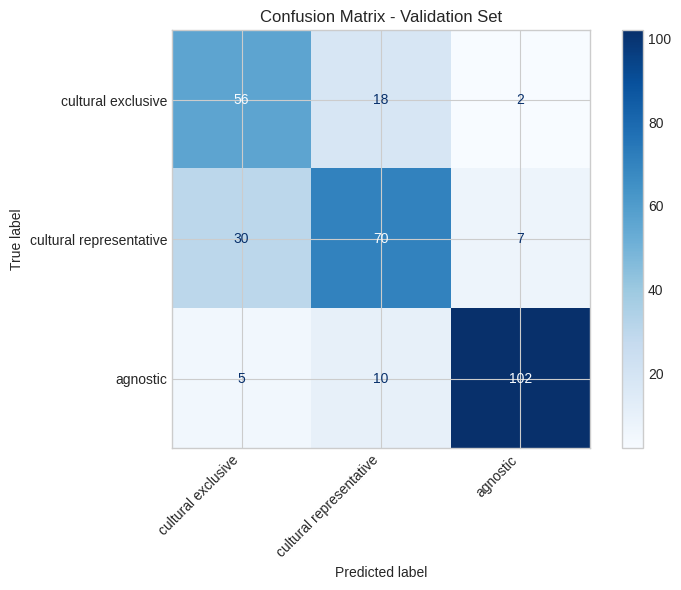


Normalized Confusion Matrix (row-wise %):


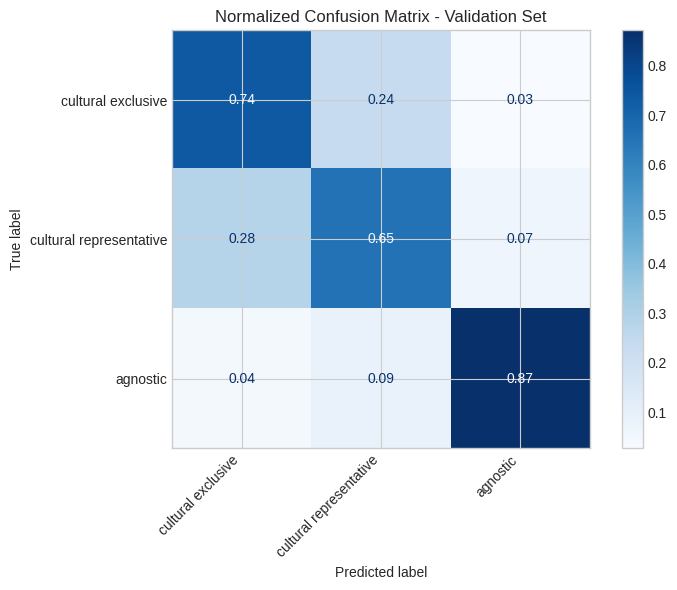


Accuracy:           0.7600
------------------------------
Precision (Macro):  0.7495
Recall (Macro):     0.7543
F1 Score (Macro):   0.7494
------------------------------
Precision (Weighted): 0.7690
Recall (Weighted):    0.7600
F1 Score (Weighted):  0.7624
------------------------------
Precision (Micro):  0.7600
Recall (Micro):     0.7600
F1 Score (Micro):   0.7600


In [35]:
training_args_eval = TrainingArguments(
    save_strategy="no",
    report_to="none",
    output_dir="./eval_dir",
    per_device_eval_batch_size=BATCH_SIZE[0] * 2,
    logging_strategy="epoch",
    fp16=torch.cuda.is_available(),
)

trainer_eval = Trainer(
    model=model,
    args=training_args_eval,
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

eval_results = trainer_eval.predict(tokenized_datasets["validation"])

all_preds = np.argmax(eval_results.predictions, axis=-1)
all_labels = eval_results.label_ids


num_classes = 3
class_names = ['cultural exclusive', 'cultural representative', 'agnostic']

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=True)
plt.title(f"Confusion Matrix - Validation Set")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Normalized Confusion Matrix
print("\nNormalized Confusion Matrix (row-wise %):")
cm_normalized = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)), normalize='true')
cm_normalized = np.nan_to_num(cm_normalized) # Handle potential NaNs if a class has no true labels
fig_norm, ax_norm = plt.subplots(figsize=(8, 6))
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp_norm.plot(cmap=plt.cm.Blues, ax=ax_norm, values_format=".2f", colorbar=True)
plt.title(f"Normalized Confusion Matrix - Validation Set")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate Scores
precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)

precision_weighted = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall_weighted = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1_weighted = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

precision_micro = precision_score(all_labels, all_preds, average='micro', zero_division=0)
recall_micro = recall_score(all_labels, all_preds, average='micro', zero_division=0)
f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)

accuracy_overall = accuracy_score(all_labels, all_preds)

# Print Scores
print(f"\nAccuracy:           {accuracy_overall:.4f}")
print("-" * 30)
print(f"Precision (Macro):  {precision_macro:.4f}")
print(f"Recall (Macro):     {recall_macro:.4f}")
print(f"F1 Score (Macro):   {f1_macro:.4f}")
print("-" * 30)
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted):    {recall_weighted:.4f}")
print(f"F1 Score (Weighted):  {f1_weighted:.4f}")
print("-" * 30)
print(f"Precision (Micro):  {precision_micro:.4f}")
print(f"Recall (Micro):     {recall_micro:.4f}")
print(f"F1 Score (Micro):   {f1_micro:.4f}")
print("="*30)

### Inference on the Test Set

In [ ]:
predictions_output = trainer_eval.predict(tokenized_datasets_test)
predicted_indices = np.argmax(predictions_output.predictions, axis=-1)
index_to_label = {0: 'cultural exclusive', 1: 'cultural representative', 2: 'cultural agnostic'}
predicted_labels = [index_to_label[idx] for idx in predicted_indices]
dataset_test_csv['label'] = predicted_labels

In [ ]:
output_filename = 'Gradient_Explorers_output_model_1.csv'
dataset_test_csv.to_csv(output_filename, index=False)